<a href="https://colab.research.google.com/github/aligoldenhat/BUSI-MobileViT-UNet/blob/main/BUSI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

inspired by https://pmc.ncbi.nlm.nih.gov/articles/PMC11429406

In [ ]:
import kagglehub
aryashah2k_breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')
aryashah2k_breast_ultrasound_images_dataset_path = aryashah2k_breast_ultrasound_images_dataset_path + "/Dataset_BUSI_with_GT"

print('Data source import complete.')

100%|██████████| 195M/195M [00:10<00:00, 19.4MB/s]

Extracting files...


Data source import complete.


### model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import MobileViTV2Config, MobileViTV2Model

In [ ]:
class UNetDecoderBlock(nn.Module):
    def __init__(self, up_in_channels, skip_in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels=up_in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        )
        self.conv_block = nn.Sequential(
            nn.Conv2d(out_channels + skip_in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        x = self.up(x)
        # Pad if needed
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])

        x = torch.cat([skip, x], dim=1)
        x = self.conv_block(x)
        return x

In [ ]:
config = MobileViTV2Config.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
config.output_hidden_states = True
a = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256", config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

In [ ]:
print(a.encoder.layer[-2:])

ModuleList(
  (0): MobileViTV2Layer(
    (downsampling_layer): MobileViTV2InvertedResidual(
      (expand_1x1): MobileViTV2ConvLayer(
        (convolution): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (conv_3x3): MobileViTV2ConvLayer(
        (convolution): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=512, bias=False)
        (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (reduce_1x1): MobileViTV2ConvLayer(
        (convolution): Conv2d(512, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv_kxk): MobileViTV2ConvLayer(
      (convolution): Conv2d(384, 384, kernel_size=(

In [ ]:
class MobileViTUNet(nn.Module):
    def __init__(self, model, num_classes=1):
        super().__init__()
        # 1) Load MobileViT (pretrained), with hidden states
        self.encoder = model

        # 2) Build 4 decoder stages, matching hidden-state shapes:
        #    final layer has 512 -> skip = 384 => out=256
        self.dec1 = UNetDecoderBlock(512, 384, 256)
        # next stage: up_in=256 -> skip=256 -> out=128
        self.dec2 = UNetDecoderBlock(256, 256, 128)
        # next stage: up_in=128 -> skip=128 -> out=64
        self.dec3 = UNetDecoderBlock(128, 128, 64)
        # final stage: up_in=64 -> skip=64 -> out=32
        self.dec4 = UNetDecoderBlock(64, 64, 32)

        # 3) Output segmentation head (1x1 conv)
        self.seg_head = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # 1) Pass through MobileViT
        out = self.encoder(x)
        hs = out.hidden_states  # list of length 5

        # index: 0->(64), 1->(128), 2->(256), 3->(384), 4->(512)
        skip0 = hs[0]
        skip1 = hs[1]
        skip2 = hs[2]
        skip3 = hs[3]
        bottleneck = hs[4]

        # 2) Decoder
        d1 = self.dec1(bottleneck, skip3)
        d2 = self.dec2(d1, skip2)
        d3 = self.dec3(d2, skip1)
        d4 = self.dec4(d3, skip0)          # -> shape [B, 32,  112,112]

        # 3) Segmentation map
        seg = self.seg_head(d4)

        # Optionally upsample to match input size (224x224):
        seg = F.interpolate(seg, size=x.shape[2:], mode="bilinear", align_corners=False)
        return seg

In [ ]:
config = MobileViTV2Config.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
config.output_hidden_states = True
mobilevitV2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256", config=config)
model = MobileViTUNet(mobilevitV2)

In [ ]:
print(model)

MobileViTUNet(
  (encoder): MobileViTV2Model(
    (conv_stem): MobileViTV2ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTV2Encoder(
      (layer): ModuleList(
        (0): MobileViTV2MobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTV2InvertedResidual(
              (expand_1x1): MobileViTV2ConvLayer(
                (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTV2ConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (normaliz

## the rest

In [ ]:
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from PIL import Image
from sklearn.model_selection import train_test_split

class BUSIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask

def get_image_mask_paths(root_dir):
    image_paths, mask_paths = [], []
    for class_name in ['benign', 'malignant']:
        class_dir = os.path.join(root_dir, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.png') and '_mask' not in img_file:
                base_name = os.path.splitext(img_file)[0]
                mask_file = f"{base_name}_mask.png"
                mask_path = os.path.join(class_dir, mask_file)
                if os.path.exists(mask_path):
                    image_paths.append(os.path.join(class_dir, img_file))
                    mask_paths.append(mask_path)
    return image_paths, mask_paths

def train_transform(image, mask):
    # Random rotation
    angle = random.uniform(-20, 20)
    image = TF.rotate(image, angle)
    mask = TF.rotate(mask, angle)
    # Random flips
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)
    # Resize and convert to tensor
    image = TF.resize(image, (224, 224))
    mask = TF.resize(mask, (224, 224))
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)
    # Normalize image (MobileViT expects mean=0.5, std=0.5)
    image = TF.normalize(image, [0.5]*3, [0.5]*3)
    # Binarize mask
    mask = (mask > 0.5).float()
    return image, mask

def val_transform(image, mask):
    # Resize and convert to tensor
    image = TF.resize(image, (224, 224))
    mask = TF.resize(mask, (224, 224))
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)
    # Normalize image
    image = TF.normalize(image, [0.5]*3, [0.5]*3)
    mask = (mask > 0.5).float()
    return image, mask

# Example usage
root_dir = aryashah2k_breast_ultrasound_images_dataset_path
image_paths, mask_paths = get_image_mask_paths(root_dir)
train_img, temp_img, train_msk, temp_msk = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
val_img, test_img, val_msk, test_msk = train_test_split(temp_img, temp_msk, test_size=0.5, random_state=42)

train_dataset = BUSIDataset(train_img, train_msk, train_transform)
val_dataset = BUSIDataset(val_img, val_msk, val_transform)
test_dataset = BUSIDataset(test_img, test_msk, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def compute_accuracy(predicted_logits, true_labels):
    """Compute semantic segmentation accuracy."""
    predicted_probs = torch.sigmoid(predicted_logits)
    predicted_classes = (predicted_probs > 0.5).long()
    true_classes = true_labels.long()
    correct_pixels = (predicted_classes == true_classes).sum().float()
    total_pixels = true_classes.numel()

    return correct_pixels / total_pixels

In [ ]:
import torch.optim as optim

def train_loop(model):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = MobileViTUNet(model=model, num_classes=1).to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  best_val_loss = float('inf')
  patience, patience_counter = 10, 0

  for epoch in range(50):
      # Training
      model.train()
      train_loss = 0.0
      for images, masks in train_loader:
          images, masks = images.to(device), masks.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
      train_loss /= len(train_loader.dataset)

      # Validation
      model.eval()
      val_loss = 0.0
      val_acc = 0.0
      with torch.no_grad():
          for images, masks in val_loader:
              images, masks = images.to(device), masks.to(device)
              outputs = model(images)

              # Compute loss
              loss = criterion(outputs, masks)
              val_loss += loss.item() * images.size(0)

              # Compute accuracy
              acc = compute_accuracy(outputs, masks)
              val_acc += acc.item() * images.size(0)

          val_loss /= len(val_loader.dataset)
          val_acc /= len(val_loader.dataset)

          print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

      # Early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model.pth')
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping triggered!")
              break

In [ ]:
# mobilevitV2
config = MobileViTV2Config.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
config.output_hidden_states = True
mobilevitV2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256", config=config)
train_loop(mobilevitV2)

Epoch 1, Train Loss: 0.3763, Val Loss: 0.2393, Val Acc: 0.9359
Epoch 2, Train Loss: 0.2551, Val Loss: 0.1884, Val Acc: 0.9359
Epoch 3, Train Loss: 0.2010, Val Loss: 0.1334, Val Acc: 0.9540
Epoch 4, Train Loss: 0.1575, Val Loss: 0.1233, Val Acc: 0.9517
Epoch 5, Train Loss: 0.1456, Val Loss: 0.1132, Val Acc: 0.9546
Epoch 6, Train Loss: 0.1302, Val Loss: 0.0964, Val Acc: 0.9631
Epoch 7, Train Loss: 0.1242, Val Loss: 0.0928, Val Acc: 0.9638
Epoch 8, Train Loss: 0.1155, Val Loss: 0.0909, Val Acc: 0.9649
Epoch 9, Train Loss: 0.1138, Val Loss: 0.0883, Val Acc: 0.9660
Epoch 10, Train Loss: 0.1057, Val Loss: 0.0898, Val Acc: 0.9670
Epoch 11, Train Loss: 0.1083, Val Loss: 0.0766, Val Acc: 0.9699
Epoch 12, Train Loss: 0.0987, Val Loss: 0.0838, Val Acc: 0.9682
Epoch 13, Train Loss: 0.0990, Val Loss: 0.0947, Val Acc: 0.9641
Epoch 14, Train Loss: 0.0939, Val Loss: 0.0726, Val Acc: 0.9704
Epoch 15, Train Loss: 0.0876, Val Loss: 0.0764, Val Acc: 0.9692
Epoch 16, Train Loss: 0.0849, Val Loss: 0.0693, V

In [ ]:
def compute_metrics(model, loader, device):
    model.eval()
    tp, fp, fn = 0, 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).float()

            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            tp += (preds_flat * masks_flat).sum().item()
            fp += (preds_flat * (1 - masks_flat)).sum().item()
            fn += ((1 - preds_flat) * masks_flat).sum().item()

    eps = 1e-7
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    iou = tp / (tp + fp + fn + eps)
    return dice, iou, precision, recall

# Load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileViTUNet(model=mobilevitV2, num_classes=1).to(device)
model.load_state_dict(torch.load('best_model.pth'))
dice, iou, precision, recall = compute_metrics(model, test_loader, device)
print(f"Dice: {dice:.4f}, IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

<ipython-input-14-7d6063cbcf6b>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Dice: 0.8166, IoU: 0.6901, Precision: 0.8256, Recall: 0.8079


# test the model

<ipython-input-39-9d8e97b20c98>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


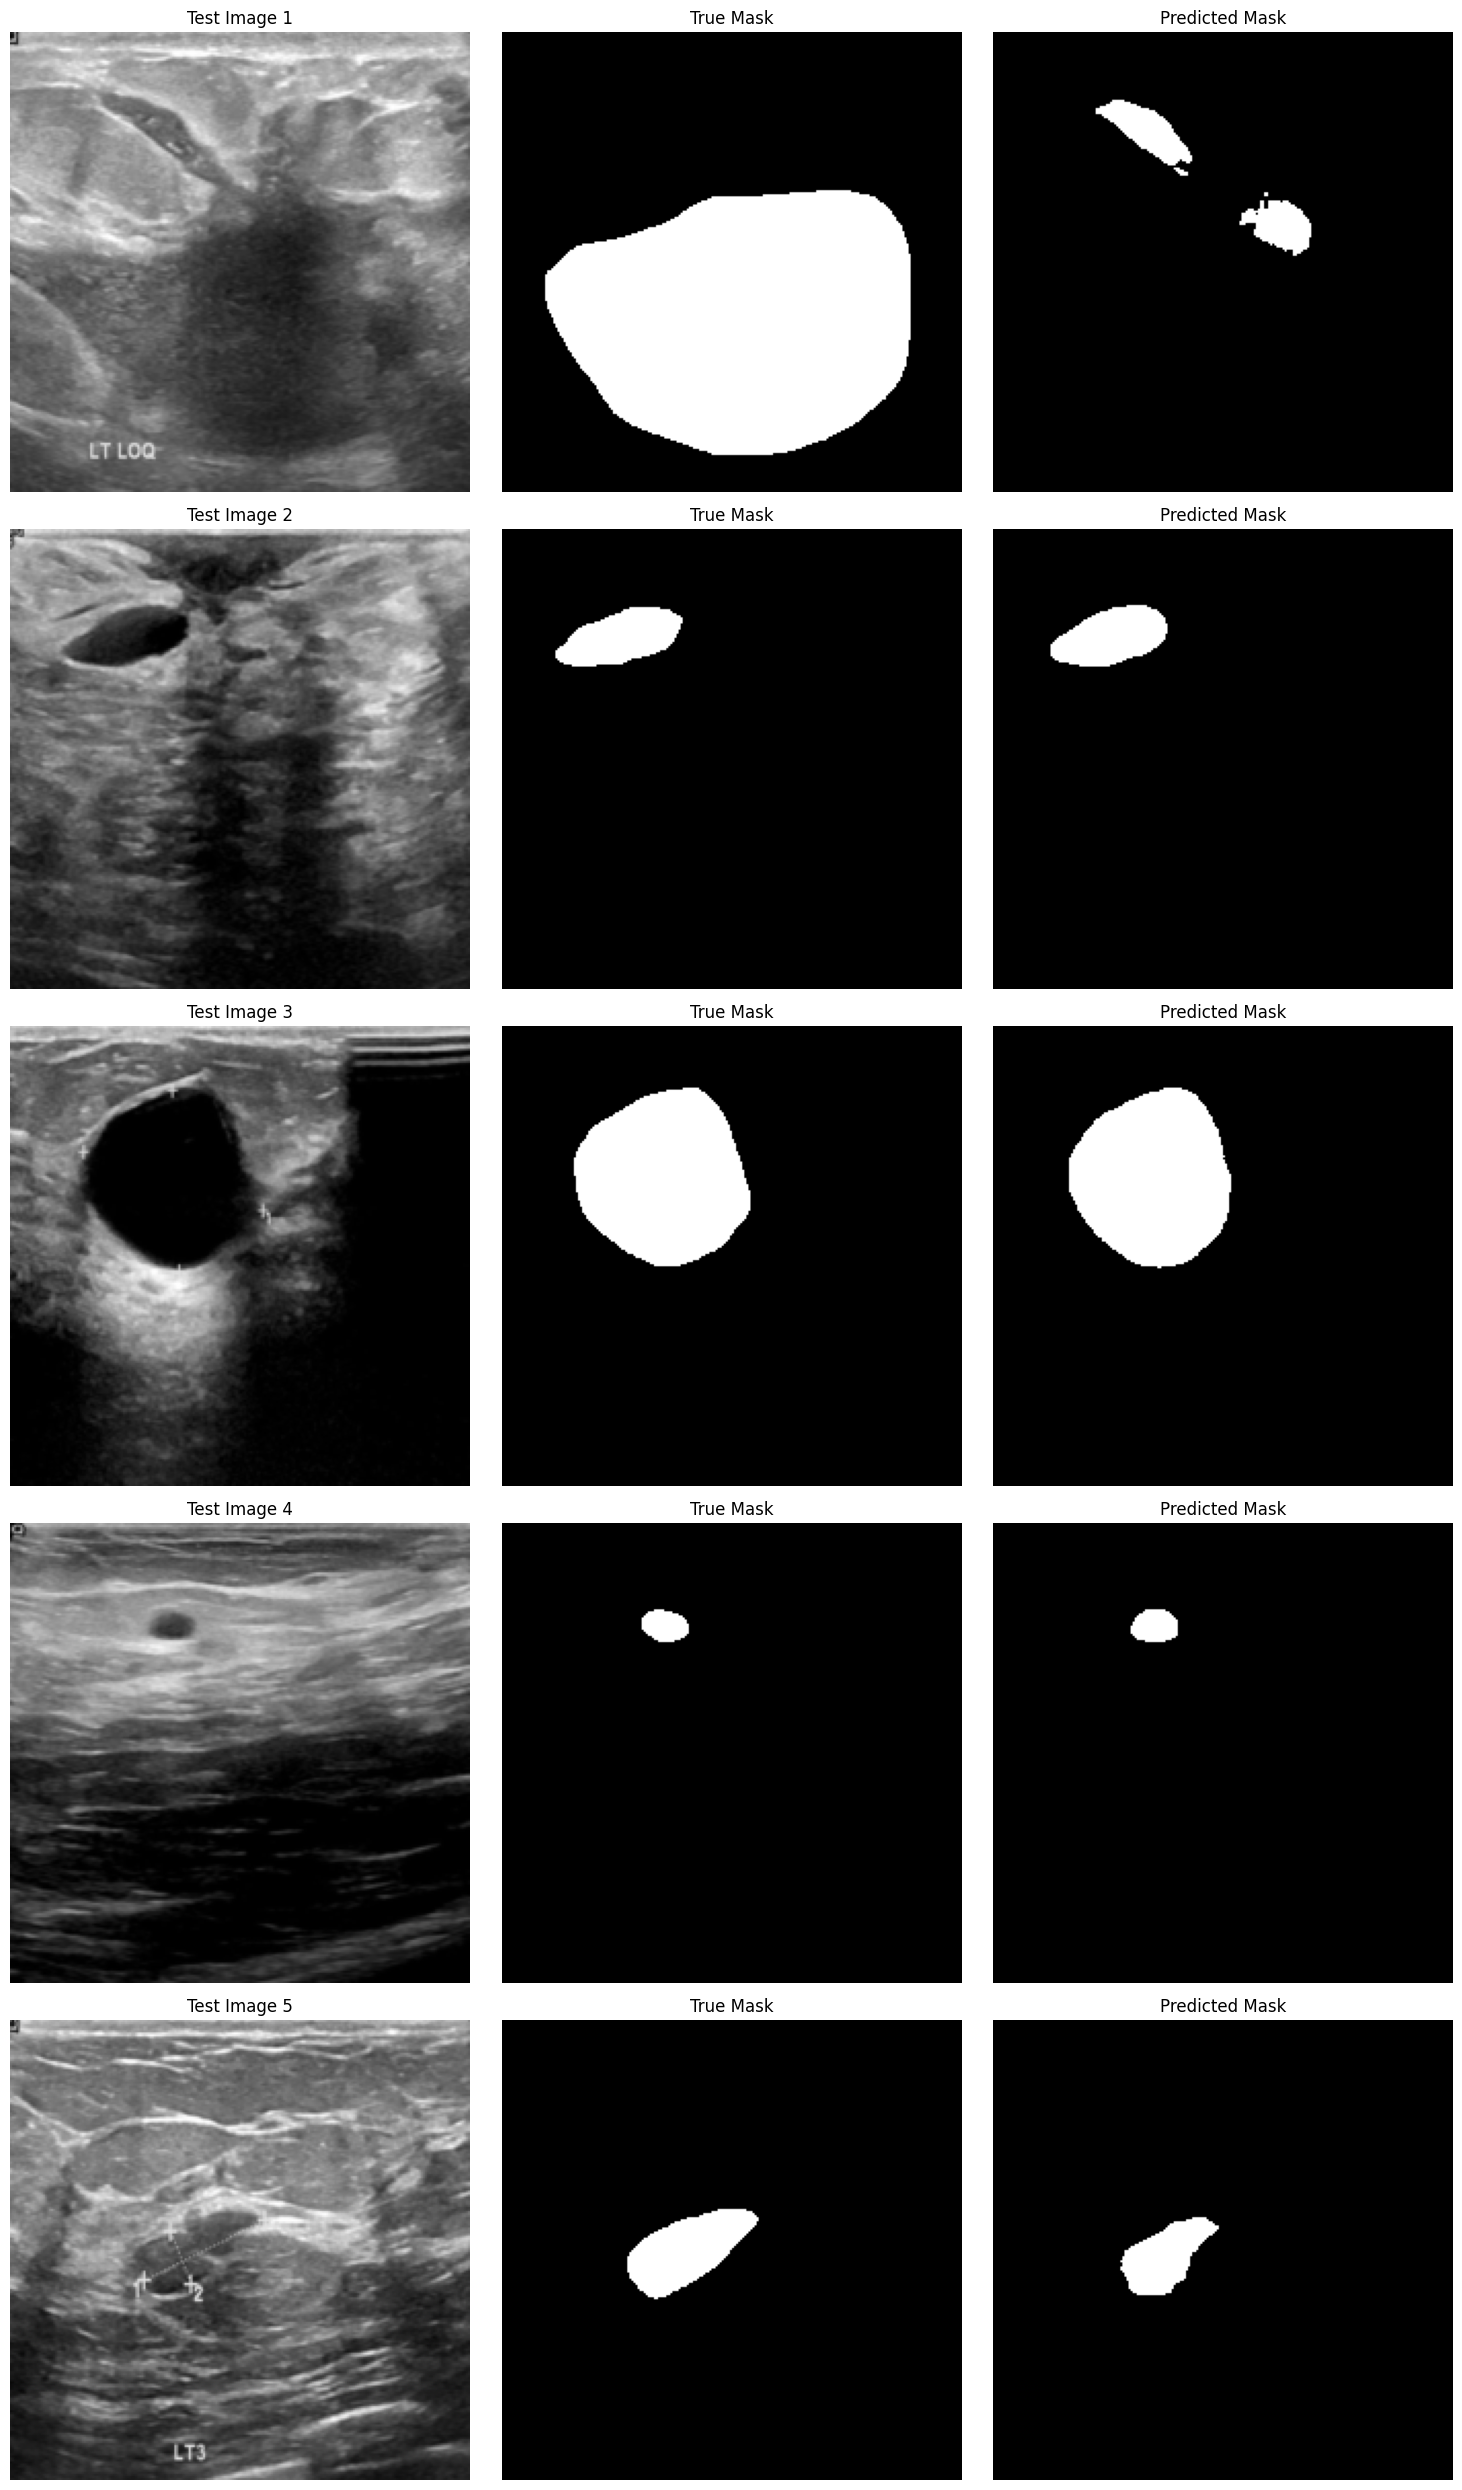

In [ ]:
import matplotlib.pyplot as plt

def plot_test_predictions(model, test_loader, device, num_samples=3):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    images, true_masks = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        pred_logits = model(images)
    pred_masks = torch.sigmoid(pred_logits).cpu().numpy()
    pred_masks = (pred_masks > 0.5).astype(np.float32)

    images = images.cpu().numpy()
    true_masks = true_masks.numpy()

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        img = images[i].transpose(1, 2, 0)
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)

        true_mask = true_masks[i].squeeze()
        pred_mask = pred_masks[i].squeeze()

        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Test Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileViTUNet(num_classes=1).to(device)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

plot_test_predictions(model, test_loader, device, num_samples=5)